In [1]:
from database import Database, LoadDatabase
import pickle, time, math, bz2, os
from numba import njit, vectorize
import matplotlib.pyplot as plt
import numpy as np

os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'

In [2]:
# helpers
def prepare_data(db):
    CALCS_FILE = "calcs.pickle.bz2"    
    # if calculated and save before, load it from file
    if os.path.exists(CALCS_FILE):
        with bz2.BZ2File(CALCS_FILE, "r") as infile:
            print("Starting loading calcs file ...")
            ret = pickle.load(infile)
            print("File read.")
    else:
        print("Starting calcs ...")
        # load database
        db = LoadDatabase()

        # collect all handles in all standings
        all_handles = set()
        for standings in db.standings.values():
            for handle in standings.index:
                all_handles.add(handle)

        # create to way mappings (id, handle)
        handle_to_id = {handle: i for i, handle in enumerate(all_handles)}
        id_to_handle = {i: handle for handle, i in handle_to_id.items()}

        # sort standings by startTime
        sorted_standings = [(k, v) for k, v in sorted(db.standings.items(), key=lambda x: db.contests.loc[x[0]].startTime)]

        # merge handles, ranks and standings length into flat array
        handle_ids_merged = []
        ranks_merged = []
        standings_lengths_merged = []

        for c_id, standings in sorted_standings:
            standings = standings.sort_values("rank")
            for handle in standings.index:
                handle_ids_merged.append(handle_to_id[handle])
                ranks_merged.append(standings["rank"][handle])
            standings_lengths_merged.append(len(standings))

        # convert them to numpy array
        handle_ids = np.array(handle_ids_merged, dtype=np.int32)
        ranks = np.array(ranks_merged, dtype=np.int32)
        standings_lens = np.array(standings_lengths_merged, dtype=np.int32)
        user_contest_cnt = np.bincount(handle_ids)
    
        with bz2.BZ2File(CALCS_FILE, "w") as outfile:
            ret = (handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt)
            pickle.dump(ret, outfile)

        print("Calcs ended.")
        
    return ret

def get_first_K_contests(K, handle_ids, ranks, standings_lens, user_contest_cnt):
    if K == -1:
        return handle_ids, ranks, standings_lens, user_contest_cnt
    K_standings_len = np.sum(standings_lens[:K])
    K_handle_ids = handle_ids[:K_standings_len]
    K_ranks = ranks[:K_standings_len]
    K_standings_lens = standings_lens[:K]
    K_user_contest_cnt = np.bincount(K_handle_ids)
    return K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt


# Additional return value of AtCoderRatingSystem, which has all calculations, meaningful variables (pretty specific)
class Result:
    def __init__(self, consider, handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens,
                 user_contest_cnt, nums, dens, aperfs, perfs, ratings, offsets, local_offsets, current_ranks,
                 Is, errors):
        self.consider = consider
        self.handle_to_id = handle_to_id
        self.id_to_handle = id_to_handle
        self.sorted_standings = sorted_standings
        self.handle_ids = handle_ids
        self.ranks = ranks
        self.standings_lens = standings_lens
        self.user_contest_cnt = user_contest_cnt
        self.nums = nums
        self.dens = dens
        self.aperfs = aperfs
        self.perfs = perfs
        self.ratings = ratings
        self.offsets = offsets
        self.local_offsets = local_offsets
        self.current_ranks = current_ranks
        self.Is = Is
        self.errors = errors
        
    def get_cf_ratings(self, handle):
        ratings = []
        if self.consider == -1:
            trimmed_standings = self.sorted_standings
        else:
            trimmed_standings = self.sorted_standings[:self.consider]
        for contest_id, standings in trimmed_standings:
            if handle in standings.index:
                ratings.append(standings.loc[handle]["oldRating"])
        return ratings
    
    def get_random_user(self, threshold=10):
        all_ids = np.arange(len(self.user_contest_cnt))
        mask = self.user_contest_cnt >= threshold
        handle_id = np.random.choice(all_ids[mask])
        return self.id_to_handle[handle_id]
    
    def plot_user(self, handle, verbose=False):
        handle_id = self.handle_to_id[handle]
        contest_cnt = self.user_contest_cnt[handle_id]
        user_offset = self.offsets[handle_id]
        print(contest_cnt, self.local_offsets[handle_id])
        assert contest_cnt == self.local_offsets[handle_id]
        
        perfs = self.perfs[user_offset:user_offset+contest_cnt]
        atcoder_ratings = self.ratings[user_offset:user_offset+contest_cnt]
        cf_ratings = self.get_cf_ratings(handle)
        
        assert contest_cnt == len(cf_ratings)
        print("number of contests", contest_cnt)
        
        if verbose:
            print("perfs", perfs)
            print("aperf", self.aperfs[handle_id])
            print("num", self.nums[handle_id])
            print("den", self.dens[handle_id])
            
        xs = np.arange(contest_cnt)
        plt.figure(figsize=(15, 8))
        plt.plot(xs, atcoder_ratings, label="AtCoder")
        plt.plot(xs, cf_ratings, label="CodeForces")
#         plt.plot(xs, perfs, label="AtCoder Perfs")
        plt.title(handle)
        plt.legend()
        plt.show()

In [3]:
# actual, main function
def AtCoderRatingSystem(db, err_fun=None,
                        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=0.9,
                        consider=50, verbose=False, **kwargs):
    
    CENTER = 1200
    RATEDBOUND = np.inf
    
    @njit(fastmath=True)
    def atcoder_calculate(handle_ids, ranks, standings_lens, user_contest_cnt,
                          verbose=True):
        user_cnt = len(user_contest_cnt)
        standings_cnt = len(standings_lens)
        history_cnt = len(handle_ids)

        def g(x):
            return np.power(g_base, x / g_power_div)

        def ginv(y):
            return g_power_div * np.log(y) / np.log(g_base)

        # AtCoder stuff
        ranks = ranks.copy().astype(np.float64)
        nums = np.zeros(user_cnt, dtype=np.float64)
        dens = np.zeros(user_cnt, dtype=np.float64)
        aperfs = np.full(user_cnt, CENTER, dtype=np.float64)
        perfs = np.empty(history_cnt, dtype=np.float64)
        ratings = np.zeros(history_cnt, dtype=np.float64)
        offsets = np.cumsum(user_contest_cnt) - user_contest_cnt
        local_offsets = np.zeros(user_cnt, dtype=np.int32)
        current_ranks = np.empty_like(ranks, dtype=np.float64)

        # parallel binsearch stuff
        ls = np.empty(np.max(standings_lens), dtype=np.float64)
        rs = np.empty(np.max(standings_lens), dtype=np.float64)
        cnts = np.empty(np.max(standings_lens), dtype=np.int32)
        handles = np.empty(np.max(standings_lens), dtype=np.int32)
        ls_next = np.empty_like(ls)
        rs_next = np.empty_like(rs)
        cnts_next = np.empty_like(cnts)
        handle_to_rank = np.empty(user_cnt, dtype=np.int32)

        standings_offset = 0
        standings_left = len(standings_lens)

        for i in range(standings_cnt):
            if verbose:
                print("Standings left:", standings_left)
            standings_left -= 1
            standings_len = standings_lens[i]

            # fix ranks
            j = 0
            while j < standings_len:
                rank = ranks[standings_offset + j]
                k = j
                while k + 1 < standings_len and ranks[standings_offset + k + 1] == rank:
                    k += 1
                ranks[j:k + 1] = (2 * rank + k - j) / 2
                j = k + 1

            # create handle -> rank mapping given current standings
            slice_l, slice_r = standings_offset, standings_offset + standings_len
            handle_to_rank[handle_ids[slice_l:slice_r]] = ranks[slice_l:slice_r]

            # prepare to parallel binsearch
            ls[0], rs[0] = 0, 5000
            cnts[0] = standings_len
            handles[:standings_len] = handle_ids[slice_l:slice_r]
            segs, segs_next = 1, 0
            handles_offset = 0
            max_iters = 80

            # do parallel binsearch
            for j in range(max_iters):
                updated = False

                for k in range(segs):
                    l, r = ls[k], rs[k]
                    cnt = cnts[k]

                    if (r - l) <= 1e-1:
                        ls_next[segs_next] = l
                        rs_next[segs_next] = r
                        cnts_next[segs_next] = cnt
                        handles_offset += cnt
                        segs_next += 1
                    else:
                        updated = True
                        m = (l + r) / 2

                        val = 0.0
                        for t in range(standings_len):
                            handle_id = handle_ids[standings_offset + t]
                            aperf = aperfs[handle_id]
                            val += 1 / (1 + np.power(binsearch_base, (m - aperf) / binsearch_power_div))

                        lit, rit = handles_offset, handles_offset + cnt - 1
                        lefts, rights = 0, 0
                        while lit < rit:
                            lhandle_id = handles[lit]
                            lrank = handle_to_rank[lhandle_id]
                            if val <= lrank - 0.5:
                                lit += 1
                                lefts += 1
                                continue

                            rhandle_id = handles[rit]
                            rrank = handle_to_rank[rhandle_id]
                            if val > rrank - 0.5:
                                rit -= 1
                                rights += 1
                                continue

                            lefts += 1
                            rights += 1
                            handles[lit], handles[rit] = handles[rit], handles[lit]
                            lit += 1
                            rit -= 1

                        if lit == rit:
                            handle_id = handles[lit]
                            rank = handle_to_rank[handle_id]
                            if val <= rank - 0.5:
                                lefts += 1
                            else:
                                rights += 1

                        if lefts > 0:
                            ls_next[segs_next] = l
                            rs_next[segs_next] = m
                            cnts_next[segs_next] = lefts
                            segs_next += 1

                        if rights > 0:
                            ls_next[segs_next] = m
                            rs_next[segs_next] = r
                            cnts_next[segs_next] = rights
                            segs_next += 1

                        handles_offset += cnt

                if not updated:
                    break

                segs = segs_next
                ls[:segs] = ls_next[:segs]
                rs[:segs] = rs_next[:segs]
                cnts[:segs] = cnts_next[:segs]
                segs_next = 0
                handles_offset = 0

            # calculate perfs, ratings, ... after parallel binsearch
            handles_offset = 0
            for j in range(segs):
                perf_base = ls[j]
                cnt = cnts[j]

                for k in range(cnt):
                    handle_id = handles[handles_offset + k]
                    offset = offsets[handle_id]
                    local_offset = local_offsets[handle_id]

                    if local_offset == 0:
                        perf = (perf_base - CENTER) * 1.5 + CENTER
                        ratings[offset + local_offset] = CENTER
                    else:
                        perf = perf_base
                        den = dens[handle_id]
                        last_sum = g(ratings[offset + local_offset - 1]) * den
                        rperf = min(perfs[offset + local_offset - 1], RATEDBOUND + 400)
                        ratings[offset + local_offset] = ginv((decay * (last_sum + g(rperf))) / (decay * (1 + den)))

                    perfs[offset + local_offset] = perf
                    nums[handle_id] = decay * (perf + nums[handle_id])
                    dens[handle_id] = decay * (1 + dens[handle_id])
                    aperfs[handle_id] = nums[handle_id] / dens[handle_id]

                handles_offset += cnt

            # move user ratings to one place
            for j in range(standings_len):
                handle_id = handle_ids[standings_offset + j]
                offset = offsets[handle_id]
                local_offset = local_offsets[handle_id]
                current_ranks[standings_offset + j] = ratings[offset + local_offset]
                local_offsets[handle_id] += 1

            standings_offset += standings_len

        return nums, dens, aperfs, perfs, ratings, offsets, local_offsets, current_ranks

    @njit(fastmath=True)
    def calculate_errors(err_fun, standings_lens, ranks, current_ranks, Is, verbose=True):
        standings_cnt = len(standings_lens)
        current_ranks = current_ranks.copy()
        errors = np.empty(standings_cnt, dtype=np.float64)

        standings_offset = 0
        standings_left = standings_cnt

        for i in range(standings_cnt):
            if verbose:
                print("Standings left:", standings_left)
            standings_left -= 1
            standings_len = standings_lens[i]

            # replace ratings with ranks
            j = 0
            while j < standings_len:
                current_rank = current_ranks[Is[standings_offset + j]]
                k = j
                while k + 1 < standings_len and current_ranks[Is[standings_offset + k + 1]] == current_rank:
                    k += 1
                first = j + 1
                last = k + 1
                current_ranks[Is[standings_offset + j:standings_offset + k + 1]] = (first + last) / 2
                j = k + 1

            # calculate errors
            err = 0
            for j in range(standings_len):
                real_rank = ranks[standings_offset + j]
                expected_rank = current_ranks[standings_offset + j]
                err += err_fun(real_rank, expected_rank)
            errors[i] = err / standings_len

            standings_offset += standings_len

        return errors
    
    ################ actual function ################
    global handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt
    # get data in familiar form
    if not "handle_to_id" in globals():
        handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt = \
            prepare_data(db)
        
    # convert err_fun to list of jitted err funs
    try:
        iter(err_fun)
    except:
        err_fun = [err_fun]
    err_fun = list(map(njit(fastmath=True), err_fun))
    
    # compile (jit)
    compile_handle_ids, compile_ranks, compile_standings_lens, compile_user_contest_cnt = \
        get_first_K_contests(5,  handle_ids, ranks, standings_lens, user_contest_cnt)
    atcoder_calculate(compile_handle_ids, compile_ranks, compile_standings_lens, compile_user_contest_cnt,
                      verbose=False)

    # main calculations
    K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt = \
        get_first_K_contests(consider, handle_ids, ranks, standings_lens, user_contest_cnt)
    t = time.time()
    nums, dens, aperfs, perfs, ratings, offsets, local_offsets, current_ranks = \
        atcoder_calculate(K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt,
                          verbose=verbose)
    delta = time.time() - t
    print("Calculated in %02dm %02.2fs" % (delta // 60, delta % 60))
    
    # some assertions haven't killed anybody, yet
    for i in range(len(K_user_contest_cnt)):
        assert K_user_contest_cnt[i] == local_offsets[i]
        
    # sort ratings in all contests to calculate error rate (argsort forbidden in numba ??)
    Is = np.empty_like(current_ranks, dtype=np.int32)
    standings_offset = 0
    standings_cnt = len(K_standings_lens)

    for i in range(standings_cnt):
        standings_len = K_standings_lens[i]
        slice_l, slice_r = standings_offset, standings_offset + standings_len
        Is[slice_l:slice_r] = standings_offset + np.argsort(current_ranks[slice_l:slice_r])
        standings_offset += standings_len
    
    # errors
    errors_dict = {}
    trimmed_sorted_standings = sorted_standings[:consider] if consider != -1 else sorted_standings
    for err_f in err_fun:
        errors = calculate_errors(err_f, K_standings_lens, ranks, current_ranks, Is, verbose=False)
        current_errors = {}
        for i, (contest_id, _) in enumerate(trimmed_sorted_standings):
            current_errors[contest_id] = errors[i]
        errors_dict[err_f.__name__] = current_errors
    
    return errors_dict, Result(consider, handle_to_id, id_to_handle, sorted_standings, K_handle_ids,
                               K_ranks, K_standings_lens, K_user_contest_cnt, nums, dens, aperfs, perfs,
                               ratings, offsets, local_offsets, current_ranks, Is, errors)

In [4]:
# error functions
def sqrt_err(x, y):
    return np.sqrt(np.abs(x - y))

def linear_err(x, y):
    return np.abs(x - y)

def squared_err(x, y):
    return np.power(x - y, 2)

In [5]:
db = LoadDatabase()

In [6]:
errors, results = AtCoderRatingSystem(db, 
        err_fun=[linear_err, sqrt_err, squared_err],
        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=0.9,
        consider=50, verbose=True)

Starting loading calcs file ...
File read.
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings left: 32
Standings left: 31
Standings left: 30
Standings left: 29
Standings left: 28
Standings left: 27
Standings left: 26
Standings left: 25
Standings left: 24
Standings left: 23
Standings left: 22
Standings left: 21
Standings left: 20
Standings left: 19
Standings left: 18
Standings left: 17
Standings left: 16
Standings left: 15
Standings left: 14
Standings left: 13
Standings left: 12
Standings left: 11
Standings left: 10
Standings left: 9
Standings left: 8
Standings left: 7
Standings left: 6
Standings left: 5
Standings left: 4
Standings left: 3
Standings left: 2
Standings left: 1
Calculated in 00

43 43
number of contests 43
perfs [ 915.54107666 1322.86071777  913.61999512  670.54748535  970.76416016
 1141.35742188 1307.06787109  622.86376953  677.10876465  935.05859375
  690.76538086  725.47912598 1665.26794434 1247.10083008 1320.8770752
 1316.37573242  965.04211426 1985.85510254 1160.65979004  541.9921875
  485.30578613 1035.30883789 1450.42419434  874.09973145  885.77270508
  405.73120117 1202.0111084  1597.59521484 1285.47668457  557.17468262
  776.3671875  1117.55371094 1037.6739502  1164.4744873   949.7833252
  942.00134277 1021.57592773 1370.01037598  703.58276367  564.65148926
 1286.31591797 1038.13171387 1520.61462402]
aperf 1058.0432959269108
num 9419.783404005426
den 8.90302262702125


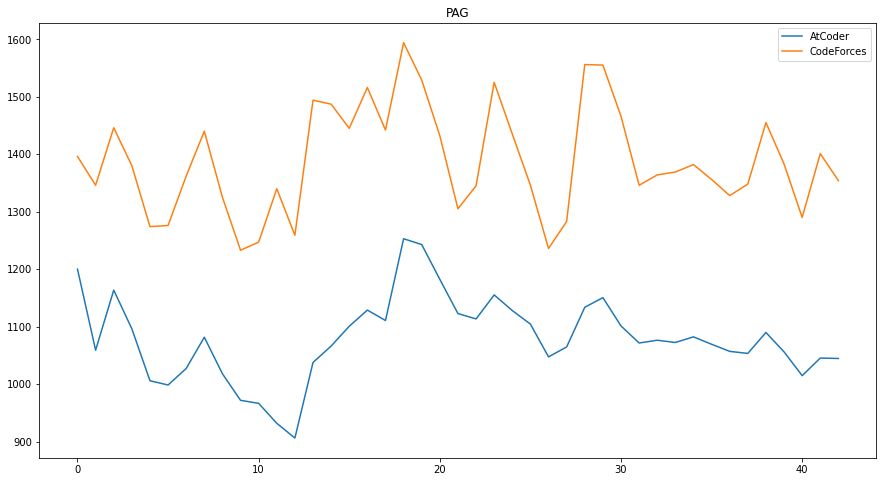

In [7]:
results.plot_user("PAG", verbose=True)